# MIPD of warfarin

In [92]:
import os

import chi
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import myokit
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme()

from model import define_wajima_model

Define convenience functions

In [57]:
def get_vk_consumption(days, nids, seed):
    """
    Returns deviations of the vk consumption from the mean consumption drawn
    from a normal distribution of shape (days, n_ids).
    """
    rng = np.random.default_rng(seed)
    vk_input = rng.normal(loc=1, scale=0.1, size=(days, nids))

    return vk_input


def define_dosing_regimen(doses, delays, cal_time=100*24):
    """
    Returns a dosing regimen with delayed administration times.
    """
    duration = 0.01
    regimen = myokit.Protocol()
    for day, dose in enumerate(doses):
        if dose == 0:
            continue
        regimen.add(myokit.ProtocolEvent(
            level=dose/duration,
            start=cal_time+day*24+delays[day],
            duration=duration))

    return regimen

## Visualise demographics of trial cohort

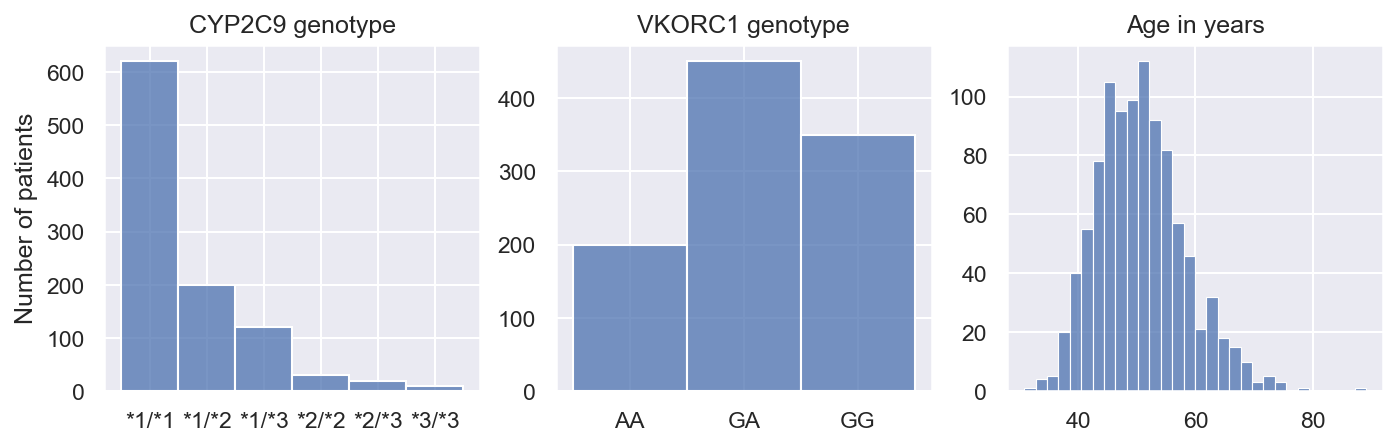

In [58]:
# Import data
directory = os.path.dirname(os.getcwd())
df_demo = pd.read_csv(directory + '/data/mipd_trial_cohort.csv')

# Reshape data
ids = df_demo.ID.dropna().unique()
cyp = []
vkorc = []
age = np.empty(len(ids))
cyp_decoder = {
    0: '*1/*1', 1: '*1/*2', 2: '*1/*3', 3: '*2/*2', 4: '*2/*3', 5: '*3/*3'}
vkorc_decoder = {0: 'GG', 1: 'GA', 2: 'AA'}
for idx, _id in enumerate(ids):
    temp = df_demo[df_demo.ID == _id]
    cyp.append(cyp_decoder[int(temp['CYP2C9'].values)])
    vkorc.append(vkorc_decoder[int(temp['VKORC1'].values)])
    age[idx] = temp['Age'].values
cyp.sort()
vkorc.sort()

# Create layout
fontsize = 11
my_dpi = 192
fig = plt.figure(figsize=(2250 // my_dpi, 700 // my_dpi), dpi=150)
outer = gridspec.GridSpec(1, 3, hspace=2.5)

# Create axes
axes = []
axes.append(plt.Subplot(fig, outer[0]))
axes.append(plt.Subplot(fig, outer[1]))
axes.append(plt.Subplot(fig, outer[2]))

# Add axes to figure
for ax in axes:
    fig.add_subplot(ax)

# Plot CYP2C9 distribution
sns.histplot(cyp, ax=axes[0])
sns.histplot(vkorc, ax=axes[1])
sns.histplot(age, ax=axes[2])

# Label axes
titles = ['CYP2C9 genotype', 'VKORC1 genotype', 'Age in years']
ylabels = ['Number of patients', '', '']
for ida, ax in enumerate(axes):
    ax.set_title(titles[ida])
    ax.set_ylabel(ylabels[ida])

plt.savefig('7_mipd_trial_demographics.pdf', bbox_inches='tight')
plt.savefig('7_mipd_trial_demographics.tif', bbox_inches='tight')

plt.show()

## Evaluate regression model

Simulate INR response for predicted dosing regimens

In [224]:
# Define model
model, _ = define_wajima_model(patient=True, inr_test=True)

# Get patient parameters
ids = df_demo.ID.dropna().unique()
parameters = np.empty(shape=(len(ids), model.n_parameters()))
for idx, _id in enumerate(ids):
    temp = df_demo[df_demo.ID == _id]
    parameters[idx] = temp[model.parameters()].values[0]

# Load dosing strategy
directory = os.path.dirname(os.getcwd())
df_doses = pd.read_csv(
    directory + '/3_regression_model'
    '/mipd_trial_predicted_dosing_regimens_deep_regression.csv')

# Convert dosing strategy to dosing regimens
# The induction doses are fixed to 10, 5 on days 1 and 2
days = 19
cal_time = 100 * 24
duration = 0.01
dosing_regimens = {}
doses = np.empty(shape=(len(df_doses.ID.dropna().unique()), days))
for idx, _id in enumerate(df_doses.ID.dropna().unique()):
    temp = df_doses[df_doses.ID == _id]
    doses[idx] = np.array([temp['Maintenance dose'].values[0]] * (days))

# Define IOV and EV
ids = df_doses.ID.dropna().unique()
rng = np.random.default_rng(seed=4)
delays = rng.exponential(scale=0.5, size=(days, len(ids)))
vk_input = get_vk_consumption(days+1, len(ids), seed=14)

# Simulate INR response to treatment
times = cal_time + np.arange(0, days+1) * 24
inrs_1 = np.empty(shape=(len(ids), len(times)))
error_model = chi.LogNormalErrorModel()
for idx, _id in enumerate(ids):
    # Set dosing regimen
    dr = define_dosing_regimen(doses[idx], delays=delays[:, idx])
    model.set_dosing_regimen(dr)

    # Simulate treatment response
    mask = ids == _id
    inrs_1[idx] = model.simulate(
        parameters=parameters[mask][0], times=times, vk_input=vk_input[:, idx])
    # Add noise
    inrs_1[idx] = error_model.sample(
        parameters=df_demo['Sigma log'].unique(), model_output=inrs_1[idx])[:, 0]

# Filter out individuals with INR > 6
dropout_1 = []
indices = []
for idx, inr in enumerate(inrs_1):
    if np.any(inr > 6):
        dropout_1.append(idx)

        # Set INRs to 8 for convenience of plotting
        inr[inr > 6] = 6
        inrs_1[idx] = inr
dropout_1 = np.array(dropout_1)

Visualise treatment response

/Users/david/Workspace/sabs-r3/mipd-warfarin/venv/lib/python3.9/site-packages/seaborn/distributions.py:243: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  baselines.iloc[:, cols] = (curves
/Users/david/Workspace/sabs-r3/mipd-warfarin/venv/lib/python3.9/site-packages/seaborn/distributions.py:243: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  baselines.iloc[:, cols] = (curves


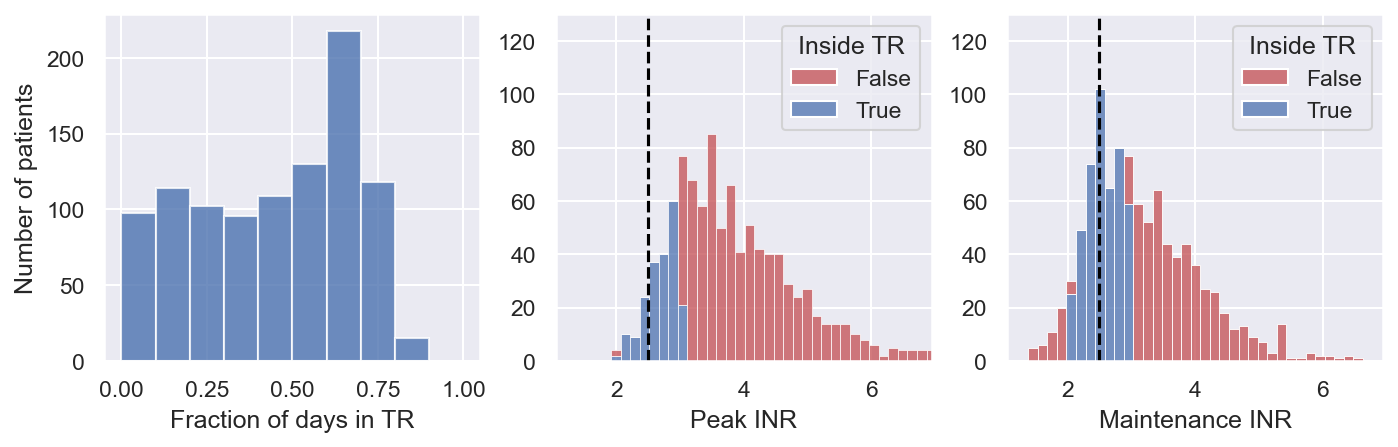

In [101]:
# Create layout
fontsize = 11
my_dpi = 192
fig = plt.figure(figsize=(2250 // my_dpi, 700 // my_dpi), dpi=150)
outer = gridspec.GridSpec(1, 3, hspace=2.5)

# Create axes
axes = []
axes.append(plt.Subplot(fig, outer[0]))
axes.append(plt.Subplot(fig, outer[1]))
axes.append(plt.Subplot(fig, outer[2]))

# Add axes to figure
for ax in axes:
    fig.add_subplot(ax)

# Plot time in therapeutic range
in_tr = (inrs_1 >= 2) & (inrs_1 <= 3)
ttr = np.mean(in_tr, axis=1)
axes[0].hist(
    ttr, bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
    color=sns.color_palette()[0], alpha=0.8)

# Plot distribution of peak INR
max_inrs = np.max(inrs_1, axis=1)
df = pd.DataFrame({
    'INR': max_inrs, 'Inside TR': (max_inrs>=2) & (max_inrs<=3)})
sns.histplot(
    df, x='INR', hue='Inside TR', ax=axes[1], multiple='stack',binwidth=0.15,
    palette=[sns.color_palette()[3], sns.color_palette()[0]])
axes[1].axvline(x=2.5, color='black', linestyle='dashed')

# # Plot maintenance INR distirbution
final_inrs = inrs_1[:, -1]
df = pd.DataFrame({
    'INR': final_inrs, 'Inside TR': (final_inrs>=2) & (final_inrs<=3)})
sns.histplot(
    df, x='INR', hue='Inside TR', ax=axes[2], multiple='stack', binwidth=0.15,
    palette=[sns.color_palette()[3], sns.color_palette()[0]])
axes[2].axvline(x=2.5, color='black', linestyle='dashed')


# Label axes
axes[0].set_xlabel('Fraction of days in TR')
axes[0].set_ylabel('Number of patients')
axes[0].set_xlim([-0.05, 1.05])
axes[1].set_xlabel('Peak INR')
axes[1].set_ylabel('')
axes[1].set_xlim([1.05, 6.95])
axes[1].set_ylim([0, 130])
axes[2].set_xlabel('Maintenance INR')
axes[2].set_ylabel('')
axes[2].set_xlim([1.05, 6.95])
axes[2].set_ylim([0, 130])

plt.savefig('7_mipd_trial_results_deep_regression.pdf', bbox_inches='tight')
plt.savefig('7_mipd_trial_results_deep_regression.tif', bbox_inches='tight')

plt.show()

Visualise dosing regimens

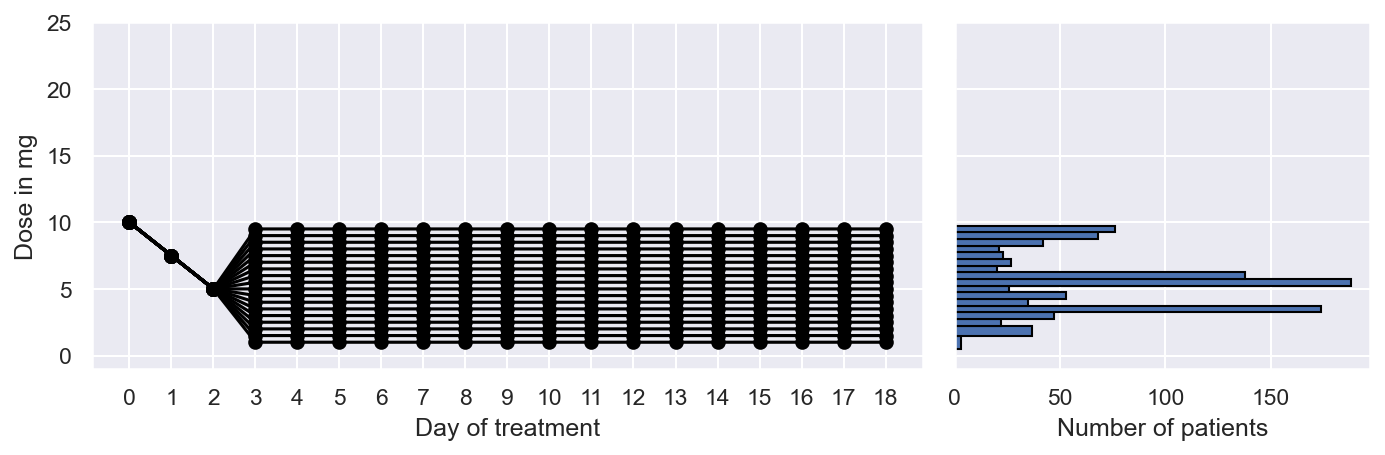

In [25]:
# Create layout
fontsize = 11
my_dpi = 192
fig = plt.figure(figsize=(2250 // my_dpi, 700 // my_dpi), dpi=150)
outer = gridspec.GridSpec(1, 2, wspace=0.05, width_ratios=[2, 1])

# Create axes
axes = []
axes.append(plt.Subplot(fig, outer[0]))
axes.append(plt.Subplot(fig, outer[1]))

# Add axes to figure
for ax in axes:
    fig.add_subplot(ax)

# Plot time in therapeutic range
maintenance_dose = {}
for d in doses:
    if str(d[-1]) in maintenance_dose.keys():
        maintenance_dose[str(d[-1])] += 1
        continue
    axes[0].plot(np.arange(days), d, marker='o', color='black')
    maintenance_dose[str(d[-1])] = 1
axes[1].hist(
    x=doses[:, -1],
    color=sns.color_palette()[0],
    orientation='horizontal',
    edgecolor='black',
    bins=[
        0, 0.5, 1.5, 2.25, 2.75, 3.25, 3.75, 4.25, 4.75, 5.25, 5.75,
        6.25, 6.75, 7.25, 7.75, 8.25, 8.75, 9.25, 9.75, 10.25, 10.75, 11.25,
        11.75, 12.25, 12.75, 13.25, 13.75, 14.25, 14.75, 15.25, 15.75, 16.25,
        16.75, 17.25, 17.75, 18.25, 18.75, 19.25, 19.75, 20.25, 20.75, 21.25,
        21.75, 22.25])

# Label axes
axes[0].set_xlabel('Day of treatment')
axes[0].set_ylabel('Dose in mg')
axes[0].set_ylim([-1, 25])
axes[0].set_xticks(list(range(days)))
axes[1].set_xlabel('Number of patients')
axes[1].set_yticklabels(labels=[], visible=False)
axes[1].set_ylim([-1, 25])
axes[1].set_ylabel('')

plt.show()

## Evaluate PKPD model (covariates only)

Simulate INR response for predicted dosing regimens

In [26]:
# Define model
model, _ = define_wajima_model(patient=True, inr_test=True)

# Get patient parameters
ids = df_demo.ID.dropna().unique()
parameters = np.empty(shape=(len(ids), model.n_parameters()))
for idx, _id in enumerate(ids):
    temp = df_demo[df_demo.ID == _id]
    parameters[idx] = temp[model.parameters()].values[0]

# Load dosing strategy
directory = os.path.dirname(os.getcwd())
df_doses = pd.read_csv(
    directory + '/2_semi_mechanistic_model'
    '/mipd_trial_predicted_dosing_regimens.csv')
df_doses = df_doses[df_doses['Number of observations'] == 0]

# Convert dosing strategy to dosing regimens
# The induction doses are fixed to 10, 5 on days 1 and 2
days = 19
cal_time = 100 * 24
duration = 0.01
dosing_regimens = {}
doses = np.empty(shape=(len(df_doses.ID.dropna().unique()), days))
for idx, _id in enumerate(df_doses.ID.dropna().unique()):
    temp = df_doses[df_doses.ID == _id]
    doses[idx] = \
        temp[['Dose %d in mg' % (idx+1) for idx in range(days)]].values[0]

# Define IOV and EV
ids = df_doses.ID.dropna().unique()
rng = np.random.default_rng(seed=4)
delays = rng.exponential(scale=0.5, size=(days, len(ids)))
vk_input = get_vk_consumption(days, len(ids), seed=14)

# Simulate INR response to treatment
times = cal_time + np.linspace(0, days, 100, endpoint=False) * 24
inrs_2 = np.empty(shape=(len(ids), len(times)))
for idx, _id in enumerate(ids):
    # Set dosing regimen
    dr = define_dosing_regimen(doses[idx], delays=delays[:, idx])
    model.set_dosing_regimen(dr)

    # Simulate treatment response
    mask = ids == _id
    inrs_2[idx] = model.simulate(
        parameters=parameters[mask][0], times=times, vk_input=vk_input[:, idx])

Visualise treatment response

/Users/david/Workspace/sabs-r3/mipd-warfarin/venv/lib/python3.9/site-packages/seaborn/distributions.py:243: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  baselines.iloc[:, cols] = (curves
/Users/david/Workspace/sabs-r3/mipd-warfarin/venv/lib/python3.9/site-packages/seaborn/distributions.py:243: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  baselines.iloc[:, cols] = (curves


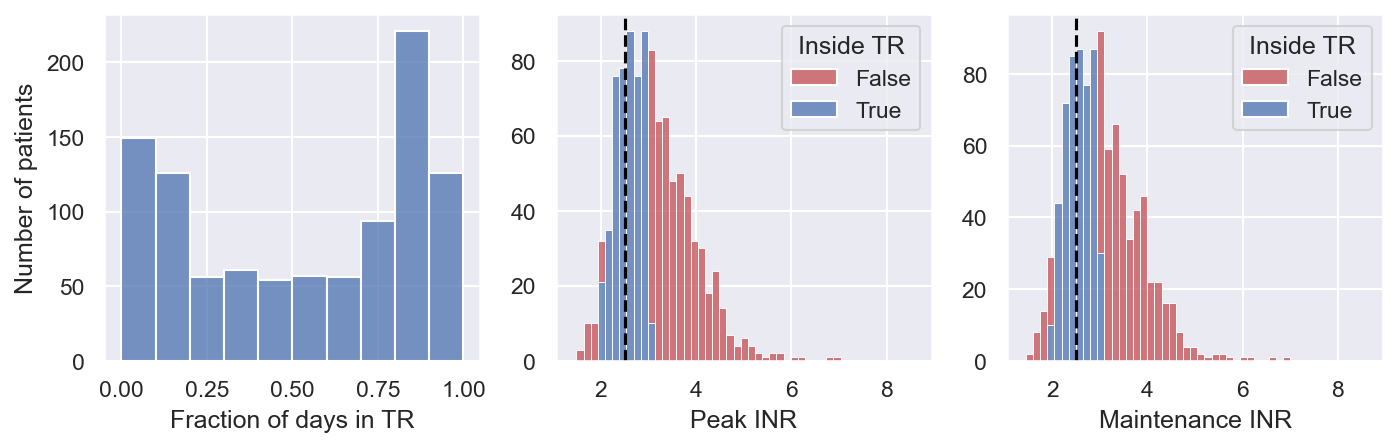

In [27]:
# Create layout
fontsize = 11
my_dpi = 192
fig = plt.figure(figsize=(2250 // my_dpi, 700 // my_dpi), dpi=150)
outer = gridspec.GridSpec(1, 3, hspace=2.5)

# Create axes
axes = []
axes.append(plt.Subplot(fig, outer[0]))
axes.append(plt.Subplot(fig, outer[1]))
axes.append(plt.Subplot(fig, outer[2]))

# Add axes to figure
for ax in axes:
    fig.add_subplot(ax)

# Plot time in therapeutic range
in_tr = (inrs_2 >= 2) & (inrs_2 <= 3)
ttr = np.mean(in_tr, axis=1)
sns.histplot(
    ttr, ax=axes[0], bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

# Plot distribution of peak INR
max_inrs = np.max(inrs_2, axis=1)
df = pd.DataFrame({
    'INR': max_inrs, 'Inside TR': (max_inrs>=2) & (max_inrs<=3)})
sns.histplot(
    df, x='INR', hue='Inside TR', ax=axes[1], multiple='stack', binwidth=0.15,
    palette=[sns.color_palette()[3], sns.color_palette()[0]])
axes[1].axvline(x=2.5, color='black', linestyle='dashed')

# # Plot maintenance INR distirbution
final_inrs = inrs_2[:, -1]
df = pd.DataFrame({
    'INR': final_inrs, 'Inside TR': (final_inrs>=2) & (final_inrs<=3)})
sns.histplot(
    df, x='INR', hue='Inside TR', ax=axes[2], multiple='stack', binwidth=0.15,
    palette=[sns.color_palette()[3], sns.color_palette()[0]])
axes[2].axvline(x=2.5, color='black', linestyle='dashed')


# Label axes
axes[0].set_xlabel('Fraction of days in TR')
axes[0].set_ylabel('Number of patients')
axes[0].set_xlim([-0.05, 1.05])
axes[1].set_xlabel('Peak INR')
axes[1].set_ylabel('')
axes[1].set_xlim([1.05, 8.95])
axes[2].set_xlabel('Maintenance INR')
axes[2].set_ylabel('')
axes[2].set_xlim([1.05, 8.95])

plt.savefig(
    '8_mipd_trial_results_pkpd_model_covariates_only.pdf', bbox_inches='tight')
plt.savefig(
    '8_mipd_trial_results_pkpd_model_covariates_only.tif', bbox_inches='tight')

plt.show()

Visualise dosing regimens

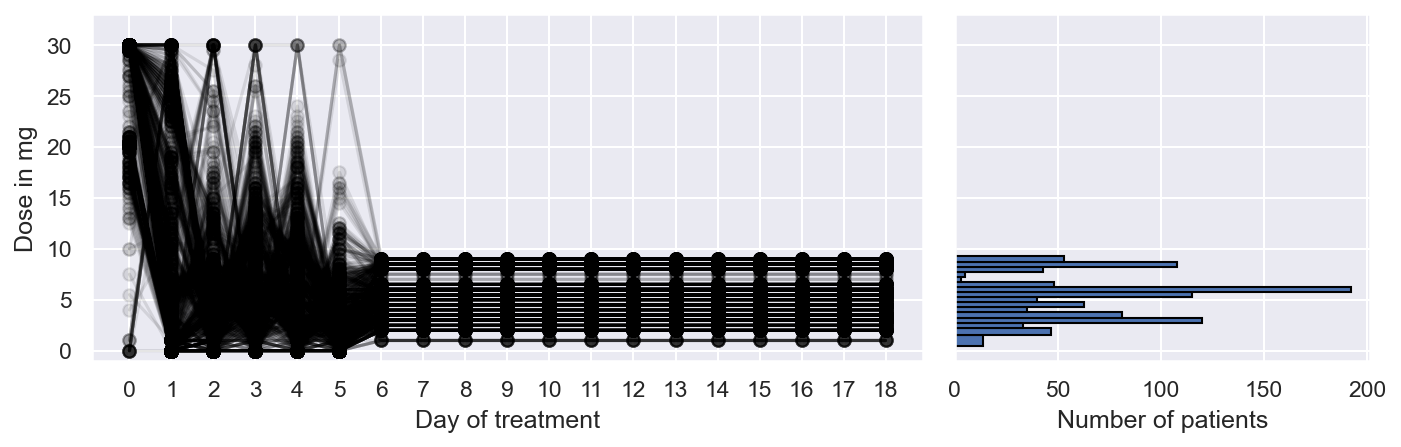

In [28]:
# Create layout
fontsize = 11
my_dpi = 192
fig = plt.figure(figsize=(2250 // my_dpi, 700 // my_dpi), dpi=150)
outer = gridspec.GridSpec(1, 2, wspace=0.05, width_ratios=[2, 1])

# Create axes
axes = []
axes.append(plt.Subplot(fig, outer[0]))
axes.append(plt.Subplot(fig, outer[1]))

# Add axes to figure
for ax in axes:
    fig.add_subplot(ax)

# Plot time in therapeutic range
maintenance_dose = {}
for d in doses:
    axes[0].plot(np.arange(days), d, marker='o', color='black', alpha=0.1)
    maintenance_dose[str(d[-1])] = 1
axes[1].hist(
    x=doses[:, -1],
    color=sns.color_palette()[0],
    orientation='horizontal',
    edgecolor='black',
    bins=[
        0, 0.5, 1.5, 2.25, 2.75, 3.25, 3.75, 4.25, 4.75, 5.25, 5.75,
        6.25, 6.75, 7.25, 7.75, 8.25, 8.75, 9.25, 9.75, 10.25, 10.75, 11.25,
        11.75, 12.25, 12.75, 13.25, 13.75, 14.25, 14.75, 15.25, 15.75])

# Label axes
axes[0].set_xlabel('Day of treatment')
axes[0].set_ylabel('Dose in mg')
axes[0].set_ylim([-1, 33])
axes[0].set_xticks(list(range(days)))
axes[1].set_xlabel('Number of patients')
axes[1].set_yticklabels(labels=[], visible=False)
axes[1].set_ylim([-1, 33])
axes[1].set_ylabel('')

plt.show()

## Evaluate DQN model

In [236]:
# Load dosing strategy
directory = os.path.dirname(os.getcwd())
data = pd.read_csv(
    directory + '/4_reinforcement_learning'
    '/mipd_trial_predicted_dosing_regimens.csv')

ids = data.ID.dropna().unique()
n_obs = data[data.ID == ids[0]]['Number of observations'].unique()
inrs_3 = np.empty((len(ids), len(n_obs), 3))
for idx, _id in enumerate(ids):
    temp = data[data.ID == _id]
    for idn, n in enumerate(n_obs):
        inrs_3[idx, idn, 0] = n - 1  # Time in days
        inrs_3[idx, idn, 1] = temp[
            temp['Number of observations'] == n].INR.values
        inrs_3[idx, idn, 2] = temp[
            temp['Number of observations'] == n]['Dose %d in mg' % n].values

# Filter out individuals with INR > 6
dropout_3 = []
indices = []
for idx, inr in enumerate(inrs_3):
    if np.any(inr[:, 1] > 6):
        dropout_3.append(idx)

        # Set INRs to 6 for convenience of plotting
        inr = inr[:, 1]
        inr[inr > 6] = 6
        inrs_3[idx, :, 1] = inr
dropout_3 = np.array(dropout_3)

Dropouts

In [178]:
len(dropout_3)

12

Visualise treatment response

/Users/david/Workspace/sabs-r3/mipd-warfarin/venv/lib/python3.9/site-packages/seaborn/distributions.py:243: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  baselines.iloc[:, cols] = (curves
/Users/david/Workspace/sabs-r3/mipd-warfarin/venv/lib/python3.9/site-packages/seaborn/distributions.py:243: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  baselines.iloc[:, cols] = (curves


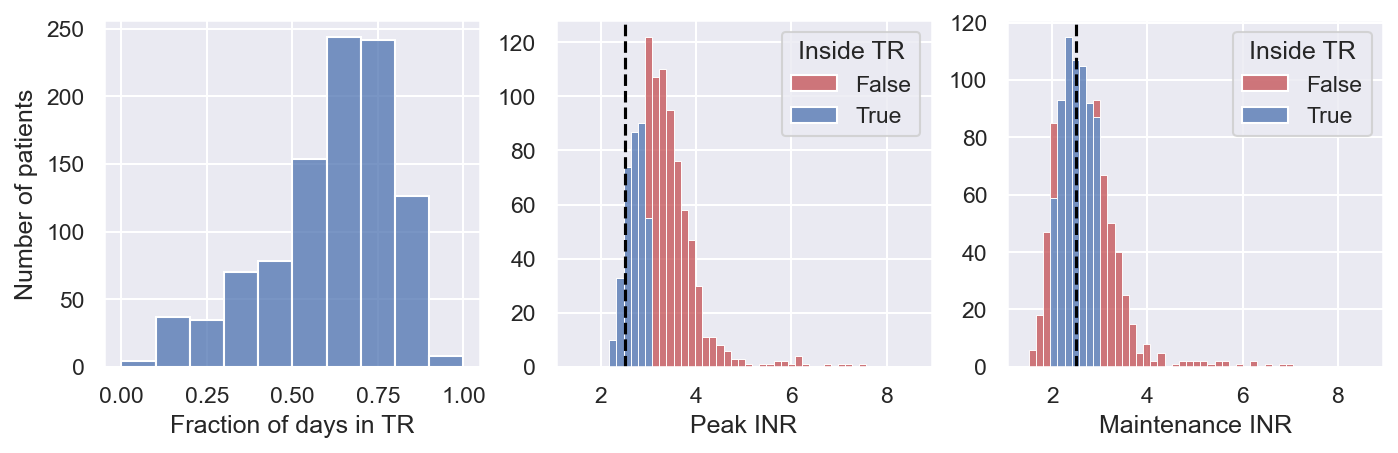

In [81]:
# Create layout
fontsize = 11
my_dpi = 192
fig = plt.figure(figsize=(2250 // my_dpi, 700 // my_dpi), dpi=150)
outer = gridspec.GridSpec(1, 3, hspace=2.5)

# Create axes
axes = []
axes.append(plt.Subplot(fig, outer[0]))
axes.append(plt.Subplot(fig, outer[1]))
axes.append(plt.Subplot(fig, outer[2]))

# Add axes to figure
for ax in axes:
    fig.add_subplot(ax)

# Plot time in therapeutic range
in_tr = (inrs_3[:, :, 1] >= 2) & (inrs_3[:, :, 1] <= 3)
ttr = np.mean(in_tr, axis=1)
sns.histplot(
    ttr, ax=axes[0], bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

# Plot distribution of peak INR
max_inrs = np.max(inrs_3[:, :, 1], axis=1)
df = pd.DataFrame({
    'INR': max_inrs, 'Inside TR': (max_inrs>=2) & (max_inrs<=3)})
sns.histplot(
    df, x='INR', hue='Inside TR', ax=axes[1], multiple='stack', binwidth=0.15,
    palette=[sns.color_palette()[3], sns.color_palette()[0]])
axes[1].axvline(x=2.5, color='black', linestyle='dashed')

# # Plot maintenance INR distirbution
final_inrs = inrs_3[:, -1, 1]
df = pd.DataFrame({
    'INR': final_inrs, 'Inside TR': (final_inrs>=2) & (final_inrs<=3)})
sns.histplot(
    df, x='INR', hue='Inside TR', ax=axes[2], multiple='stack', binwidth=0.15,
    palette=[sns.color_palette()[3], sns.color_palette()[0]])
axes[2].axvline(x=2.5, color='black', linestyle='dashed')

# Label axes
axes[0].set_xlabel('Fraction of days in TR')
axes[0].set_ylabel('Number of patients')
axes[0].set_xlim([-0.05, 1.05])
axes[1].set_xlabel('Peak INR')
axes[1].set_ylabel('')
axes[1].set_xlim([1.05, 8.95])
axes[2].set_xlabel('Maintenance INR')
axes[2].set_ylabel('')
axes[2].set_xlim([1.05, 8.95])

plt.savefig(
    '9_mipd_trial_results_dqn.pdf', bbox_inches='tight')
plt.savefig(
    '9_mipd_trial_results_dqn.tif', bbox_inches='tight')

plt.show()

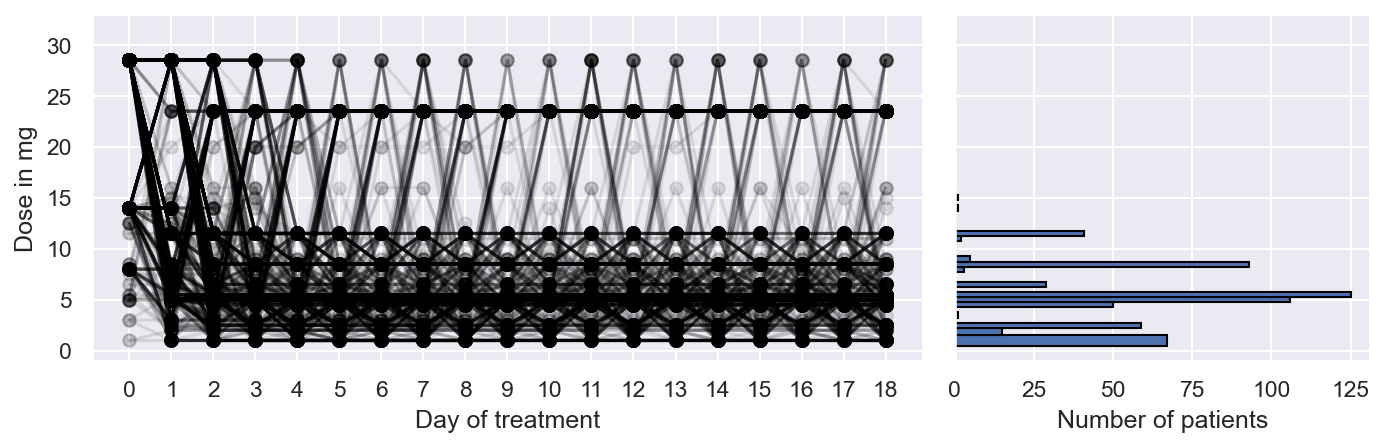

In [31]:
# Create layout
fontsize = 11
my_dpi = 192
fig = plt.figure(figsize=(2250 // my_dpi, 700 // my_dpi), dpi=150)
outer = gridspec.GridSpec(1, 2, wspace=0.05, width_ratios=[2, 1])

# Create axes
axes = []
axes.append(plt.Subplot(fig, outer[0]))
axes.append(plt.Subplot(fig, outer[1]))

# Add axes to figure
for ax in axes:
    fig.add_subplot(ax)

# Plot time in therapeutic range
maintenance_dose = {}
for d in doses:
    axes[0].plot(np.arange(days), d, marker='o', color='black', alpha=0.1)
    maintenance_dose[str(d[-1])] = 1
axes[1].hist(
    x=doses[:, -1],
    color=sns.color_palette()[0],
    orientation='horizontal',
    edgecolor='black',
    bins=[
        0, 0.5, 1.5, 2.25, 2.75, 3.25, 3.75, 4.25, 4.75, 5.25, 5.75,
        6.25, 6.75, 7.25, 7.75, 8.25, 8.75, 9.25, 9.75, 10.25, 10.75, 11.25,
        11.75, 12.25, 12.75, 13.25, 13.75, 14.25, 14.75, 15.25, 15.75])

# Label axes
axes[0].set_xlabel('Day of treatment')
axes[0].set_ylabel('Dose in mg')
axes[0].set_ylim([-1, 33])
axes[0].set_xticks(list(range(days)))
axes[1].set_xlabel('Number of patients')
axes[1].set_yticklabels(labels=[], visible=False)
axes[1].set_ylim([-1, 33])
axes[1].set_ylabel('')

plt.show()

## Evaluate PKPD model (Bayesian dosing regimen optimisation)

In [179]:
# Load dosing strategy
directory = os.path.dirname(os.getcwd())
data = pd.read_csv(
    directory + '/2_semi_mechanistic_model'
    '/mipd_trial_predicted_dosing_regimens.csv')

ids = data.ID.dropna().unique()
n_obs = data[data.ID == ids[0]]['Number of observations'].unique()
n_obs = n_obs[n_obs > 0]
inrs_4 = np.empty((len(ids), len(n_obs), 3))
for idx, _id in enumerate(ids):
    temp = data[data.ID == _id]
    for idn, n in enumerate(n_obs):
        inrs_4[idx, idn, 0] = n - 1  # Time in days
        inrs_4[idx, idn, 1] = temp[
            temp['Number of observations'] == n].INR.values
        inrs_4[idx, idn, 2] = temp[
            temp['Number of observations'] == n]['Dose %d in mg' % n].values

# Filter out individuals with INR > 6
dropout_4 = []
indices = []
for idx, inr in enumerate(inrs_4):
    if np.any(inr[:, 1] > 6):
        dropout_4.append(inr)

        # Set INRs to 6 for convenience of plotting
        inr = inr[:, 1]
        inr[inr > 6] = 6
        inrs_4[idx, :, 1] = inr
dropout_4 = np.array(dropout_4)

Visualise treatment response

/Users/david/Workspace/sabs-r3/mipd-warfarin/venv/lib/python3.9/site-packages/seaborn/distributions.py:243: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  baselines.iloc[:, cols] = (curves
/Users/david/Workspace/sabs-r3/mipd-warfarin/venv/lib/python3.9/site-packages/seaborn/distributions.py:243: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  baselines.iloc[:, cols] = (curves


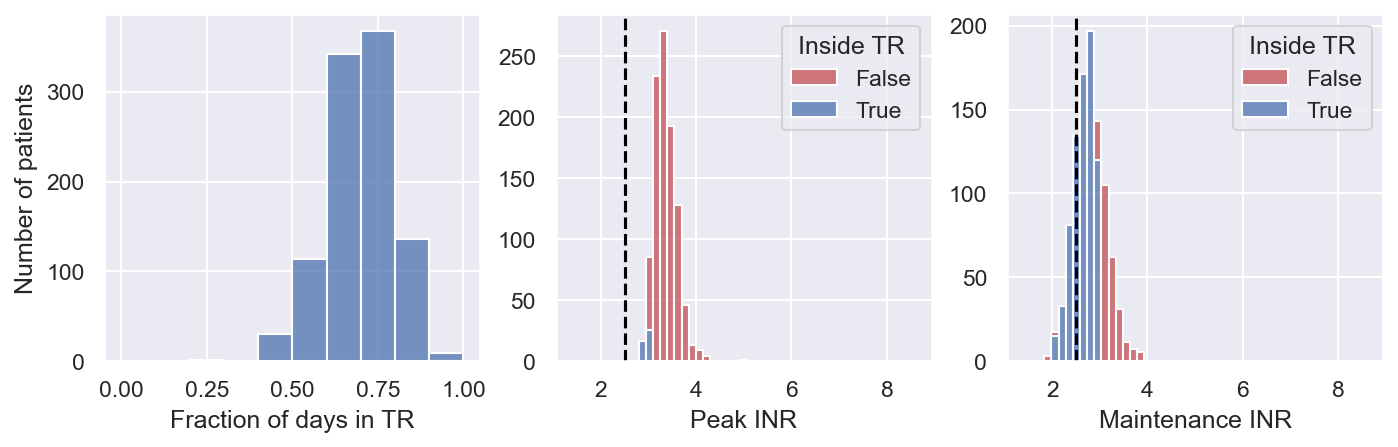

In [88]:
# Create layout
fontsize = 11
my_dpi = 192
fig = plt.figure(figsize=(2250 // my_dpi, 700 // my_dpi), dpi=150)
outer = gridspec.GridSpec(1, 3, hspace=2.5)

# Create axes
axes = []
axes.append(plt.Subplot(fig, outer[0]))
axes.append(plt.Subplot(fig, outer[1]))
axes.append(plt.Subplot(fig, outer[2]))

# Add axes to figure
for ax in axes:
    fig.add_subplot(ax)

# Plot time in therapeutic range
in_tr = (inrs_4[:, :, 1] >= 2) & (inrs_4[:, :, 1] <= 3)
ttr = np.mean(in_tr, axis=1)
sns.histplot(
    ttr, ax=axes[0], bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

# Plot distribution of peak INR
max_inrs = np.max(inrs_4[:, :, 1], axis=1)
df = pd.DataFrame({
    'INR': max_inrs, 'Inside TR': (max_inrs>=2) & (max_inrs<=3)})
sns.histplot(
    df, x='INR', hue='Inside TR', ax=axes[1], multiple='stack', binwidth=0.15,
    palette=[sns.color_palette()[3], sns.color_palette()[0]])
axes[1].axvline(x=2.5, color='black', linestyle='dashed')

# # Plot maintenance INR distirbution
final_inrs = inrs_4[:, -1, 1]
df = pd.DataFrame({
    'INR': final_inrs, 'Inside TR': (final_inrs>=2) & (final_inrs<=3)})
sns.histplot(
    df, x='INR', hue='Inside TR', ax=axes[2], multiple='stack', binwidth=0.15,
    palette=[sns.color_palette()[3], sns.color_palette()[0]])
axes[2].axvline(x=2.5, color='black', linestyle='dashed')

# Label axes
axes[0].set_xlabel('Fraction of days in TR')
axes[0].set_ylabel('Number of patients')
axes[0].set_xlim([-0.05, 1.05])
axes[1].set_xlabel('Peak INR')
axes[1].set_ylabel('')
axes[1].set_xlim([1.05, 8.95])
axes[2].set_xlabel('Maintenance INR')
axes[2].set_ylabel('')
axes[2].set_xlim([1.05, 8.95])

# plt.savefig(
#     '10_mipd_trial_results_pkpd_model_BDRO_7_tdm.pdf', bbox_inches='tight')
# plt.savefig(
#     '10_mipd_trial_results_pkpd_model_BDRO_7_tdm.tif', bbox_inches='tight')

plt.show()

Dosing strategy

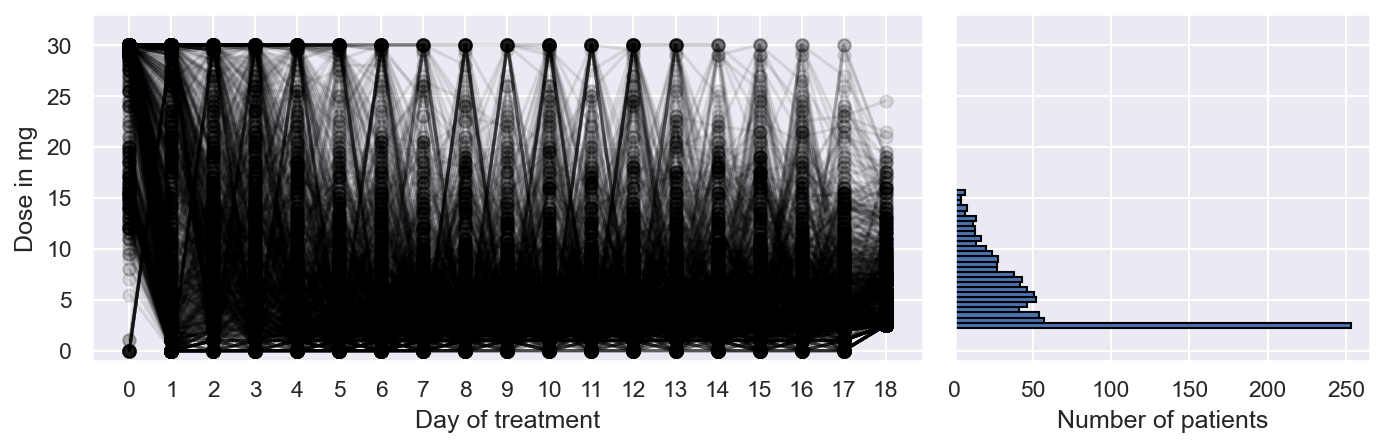

In [21]:
# Create layout
fontsize = 11
my_dpi = 192
fig = plt.figure(figsize=(2250 // my_dpi, 700 // my_dpi), dpi=150)
outer = gridspec.GridSpec(1, 2, wspace=0.05, width_ratios=[2, 1])

# Create axes
axes = []
axes.append(plt.Subplot(fig, outer[0]))
axes.append(plt.Subplot(fig, outer[1]))

# Add axes to figure
for ax in axes:
    fig.add_subplot(ax)

# Plot time in therapeutic range
maintenance_dose = {}
for d in doses:
    axes[0].plot(np.arange(days), d, marker='o', color='black', alpha=0.1)
    maintenance_dose[str(d[-1])] = 1
axes[1].hist(
    x=doses[:, -1],
    color=sns.color_palette()[0],
    orientation='horizontal',
    edgecolor='black',
    bins=[
        0, 0.5, 1.5, 2.25, 2.75, 3.25, 3.75, 4.25, 4.75, 5.25, 5.75,
        6.25, 6.75, 7.25, 7.75, 8.25, 8.75, 9.25, 9.75, 10.25, 10.75, 11.25,
        11.75, 12.25, 12.75, 13.25, 13.75, 14.25, 14.75, 15.25, 15.75])

# Label axes
axes[0].set_xlabel('Day of treatment')
axes[0].set_ylabel('Dose in mg')
axes[0].set_ylim([-1, 33])
axes[0].set_xticks(list(range(days)))
axes[1].set_xlabel('Number of patients')
axes[1].set_yticklabels(labels=[], visible=False)
axes[1].set_ylim([-1, 33])
axes[1].set_ylabel('')

plt.show()

## Summary figure

/Users/david/Workspace/sabs-r3/mipd-warfarin/venv/lib/python3.9/site-packages/seaborn/distributions.py:243: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  baselines.iloc[:, cols] = (curves
/Users/david/Workspace/sabs-r3/mipd-warfarin/venv/lib/python3.9/site-packages/seaborn/distributions.py:243: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  baselines.iloc[:, cols] = (curves
/Users/david/Workspace/sabs-r3/mipd-warfarin/venv/lib/python3.9/site-packages/seaborn/distributions.py:243: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attem

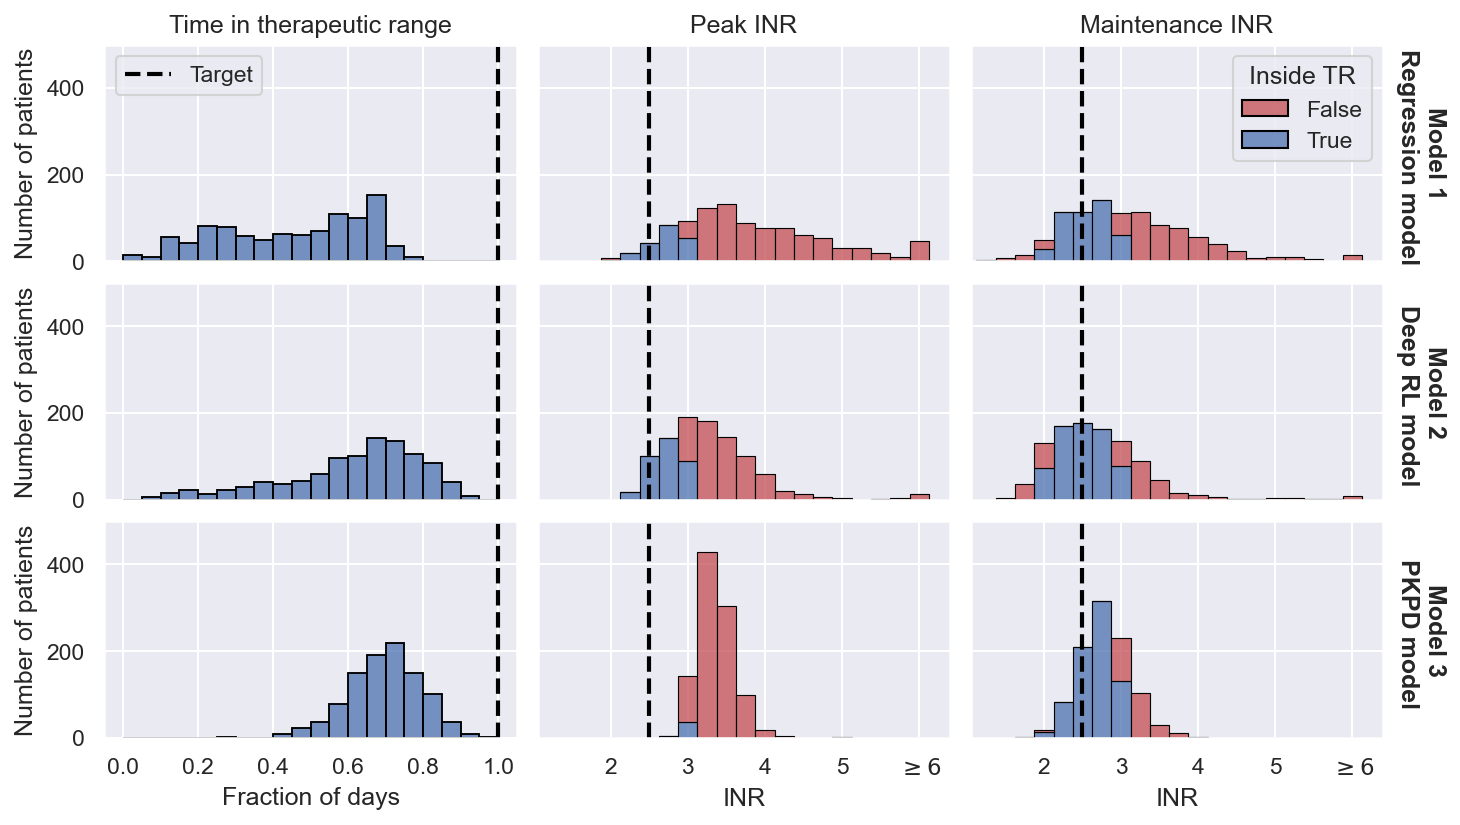

In [200]:
# Visualise results
# Create layout
fontsize = 11
my_dpi = 192
fig = plt.figure(figsize=(2250 // my_dpi, 1200 // my_dpi), dpi=150)
outer = gridspec.GridSpec(3, 1, hspace=0.1)

inner1 = gridspec.GridSpecFromSubplotSpec(
    1, 3, subplot_spec=outer[0], wspace=0.05)
inner2 = gridspec.GridSpecFromSubplotSpec(
    1, 3, subplot_spec=outer[1], wspace=0.05)
inner3 = gridspec.GridSpecFromSubplotSpec(
    1, 3, subplot_spec=outer[2], wspace=0.05)

# Create axes
axes = []
axes.append(plt.Subplot(fig, inner1[0]))
axes.append(plt.Subplot(fig, inner1[1]))
axes.append(plt.Subplot(fig, inner1[2]))
axes.append(plt.Subplot(fig, inner2[0]))
axes.append(plt.Subplot(fig, inner2[1]))
axes.append(plt.Subplot(fig, inner2[2]))
axes.append(plt.Subplot(fig, inner3[0]))
axes.append(plt.Subplot(fig, inner3[1]))
axes.append(plt.Subplot(fig, inner3[2]))

# Add axes to figure
for ax in axes:
    fig.add_subplot(ax)

# Plot time in therapeutic range
in_tr = (inrs_1 >= 2) & (inrs_1 <= 3)
ttr = np.mean(in_tr, axis=1)
bins2 = np.arange(0, 1.05, 0.05)
sns.histplot(
    ttr, ax=axes[0], bins=bins2,
    edgecolor='black')
axes[0].axvline(
    x=1, color='black', linestyle='dashed', linewidth=2, label='Target')

# Plot distribution of peak INR
bins = np.arange(0.125, 8.6, 0.25)
max_inrs = np.max(inrs_1, axis=1)
df = pd.DataFrame({
    'INR': max_inrs, 'Inside TR': (max_inrs>=2) & (max_inrs<=3)})
sns.histplot(
    df, x='INR', hue='Inside TR', ax=axes[1], multiple='stack', bins=bins,
    palette=[sns.color_palette()[3], sns.color_palette()[0]], legend=False,
    edgecolor='black')
axes[1].axvline(x=2.5, color='black', linestyle='dashed', linewidth=2)

# # Plot maintenance INR distirbution
final_inrs = inrs_1[:, -1]
df = pd.DataFrame({
    'INR': final_inrs, 'Inside TR': (final_inrs>=2) & (final_inrs<=3)})
sns.histplot(
    df, x='INR', hue='Inside TR', ax=axes[2], multiple='stack', bins=bins,
    palette=[sns.color_palette()[3], sns.color_palette()[0]],
    edgecolor='black')
axes[2].axvline(x=2.5, color='black', linestyle='dashed', linewidth=2)

# Plot time in therapeutic range
in_tr = (inrs_3[:, :, 1] >= 2) & (inrs_3[:, :, 1] <= 3)
ttr = np.mean(in_tr, axis=1)
sns.histplot(
    ttr, ax=axes[3], bins=bins2,
    edgecolor='black')
axes[3].axvline(x=1, color='black', linestyle='dashed', linewidth=2)

# Plot distribution of peak INR
max_inrs = np.max(inrs_3[:, :, 1], axis=1)
df = pd.DataFrame({
    'INR': max_inrs, 'Inside TR': (max_inrs>=2) & (max_inrs<=3)})
sns.histplot(
    df, x='INR', hue='Inside TR', ax=axes[4], multiple='stack', bins=bins,
    palette=[sns.color_palette()[3], sns.color_palette()[0]], legend=False,
    edgecolor='black')
axes[4].axvline(x=2.5, color='black', linestyle='dashed', linewidth=2)

# Plot maintenance INR distirbution
final_inrs = inrs_3[:, -1, 1]
df = pd.DataFrame({
    'INR': final_inrs, 'Inside TR': (final_inrs>=2) & (final_inrs<=3)})
sns.histplot(
    df, x='INR', hue='Inside TR', ax=axes[5], multiple='stack', bins=bins,
    palette=[sns.color_palette()[3], sns.color_palette()[0]], legend=False,
    edgecolor='black')
axes[5].axvline(x=2.5, color='black', linestyle='dashed', linewidth=2)

# Plot time in therapeutic range
in_tr = (inrs_4[:, :, 1] >= 2) & (inrs_4[:, :, 1] <= 3)
ttr = np.mean(in_tr, axis=1)
sns.histplot(
    ttr, ax=axes[6], bins=bins2,
    edgecolor='black')
axes[6].axvline(x=1, color='black', linestyle='dashed', linewidth=2)

# Plot distribution of peak INR
max_inrs = np.max(inrs_4[:, :, 1], axis=1)
df = pd.DataFrame({
    'INR': max_inrs, 'Inside TR': (max_inrs>=2) & (max_inrs<=3)})
sns.histplot(
    df, x='INR', hue='Inside TR', ax=axes[7], multiple='stack', bins=bins,
    palette=[sns.color_palette()[3], sns.color_palette()[0]], legend=False,
    edgecolor='black')
axes[7].axvline(x=2.5, color='black', linestyle='dashed', linewidth=2)

# Plot maintenance INR distirbution
final_inrs = inrs_4[:, -1, 1]
df = pd.DataFrame({
    'INR': final_inrs, 'Inside TR': (final_inrs>=2) & (final_inrs<=3)})
sns.histplot(
    df, x='INR', hue='Inside TR', ax=axes[8], multiple='stack', bins=bins,
    palette=[sns.color_palette()[3], sns.color_palette()[0]], legend=False,
    edgecolor='black')
axes[8].axvline(x=2.5, color='black', linestyle='dashed', linewidth=2)

# Label axes
axes[0].set_xlabel('')
axes[0].set_ylabel('Number of patients')
axes[0].set_xlim([-0.05, 1.05])
axes[0].set_xticklabels(labels=[], visible=False)
axes[0].set_ylim([0, 499])
axes[1].set_xlabel('')
axes[1].set_xticks([2, 3, 4, 5, 6])
axes[1].set_xticklabels(labels=[], visible=False)
axes[1].set_yticklabels(labels=[], visible=False)
axes[1].set_ylabel('')
axes[1].set_xlim([1.05, 6.4])
axes[1].set_ylim([0, 499])
axes[2].set_xlabel('')
axes[2].set_xticks([2, 3, 4, 5, 6])
axes[2].set_xticklabels(labels=[], visible=False)
axes[2].set_yticklabels(labels=[], visible=False)
axes[2].set_xlim([1.05, 6.4])
axes[2].set_ylim([0, 499])
axes[2].set_ylabel('')
axes[3].set_xlabel('')
axes[3].set_xticklabels(labels=[], visible=False)
axes[3].set_ylabel('Number of patients')
axes[3].set_xlim([-0.05, 1.05])
axes[3].set_ylim([0, 499])
axes[4].set_xlabel('')
axes[4].set_xticks([2, 3, 4, 5, 6])
axes[4].set_xticklabels(labels=[], visible=False)
axes[4].set_yticklabels(labels=[], visible=False)
axes[4].set_ylabel('')
axes[4].set_xlim([1.05, 6.4])
axes[4].set_ylim([0, 499])
axes[5].set_xlabel('')
axes[5].set_ylabel('')
axes[5].set_xticks([2, 3, 4, 5, 6])
axes[5].set_xticklabels(labels=[], visible=False)
axes[5].set_yticklabels(labels=[], visible=False)
axes[5].set_xlim([1.05, 6.4])
axes[5].set_ylim([0, 499])
axes[6].set_xlabel('Fraction of days')
axes[6].set_ylabel('Number of patients')
axes[6].set_xlim([-0.05, 1.05])
axes[6].set_ylim([0, 499])
axes[7].set_xlabel('INR')
axes[7].set_ylabel('')
axes[7].set_yticklabels(labels=[], visible=False)
axes[7].set_xticks([2, 3, 4, 5, 6])
axes[7].set_xticklabels(labels=['2', '3', '4', '5', r'$\geq6$'])
axes[7].set_xlim([1.05, 6.4])
axes[7].set_ylim([0, 499])
axes[8].set_xlabel('INR')
axes[8].set_xlim([1.05, 6.4])
axes[8].set_ylim([0, 499])
axes[8].set_ylabel('')
axes[8].set_yticklabels(labels=[], visible=False)
axes[8].set_xticks([2, 3, 4, 5, 6])
axes[8].set_xticklabels(labels=['2', '3', '4', '5', r'$\geq6$'])

axes[0].legend()

axes[0].set_title('Time in therapeutic range')
axes[1].set_title('Peak INR')
axes[2].set_title('Maintenance INR')

axes[2].yaxis.set_label_position("right")
axes[2].set_ylabel(
    'Model 1\n Regression model', rotation=-90, labelpad=30, fontweight='bold')
axes[5].yaxis.set_label_position("right")
axes[5].set_ylabel(
    'Model 2\n Deep RL model', rotation=-90, labelpad=30, fontweight='bold')
axes[8].yaxis.set_label_position("right")
axes[8].set_ylabel(
    'Model 3\n PKPD model', rotation=-90, labelpad=30, fontweight='bold')

plt.savefig('10_mipd_trial_results.pdf',
    bbox_inches='tight')
plt.savefig('10_mipd_trial_results.tif',
    bbox_inches='tight')

plt.show()

## Visualise dosing strategies

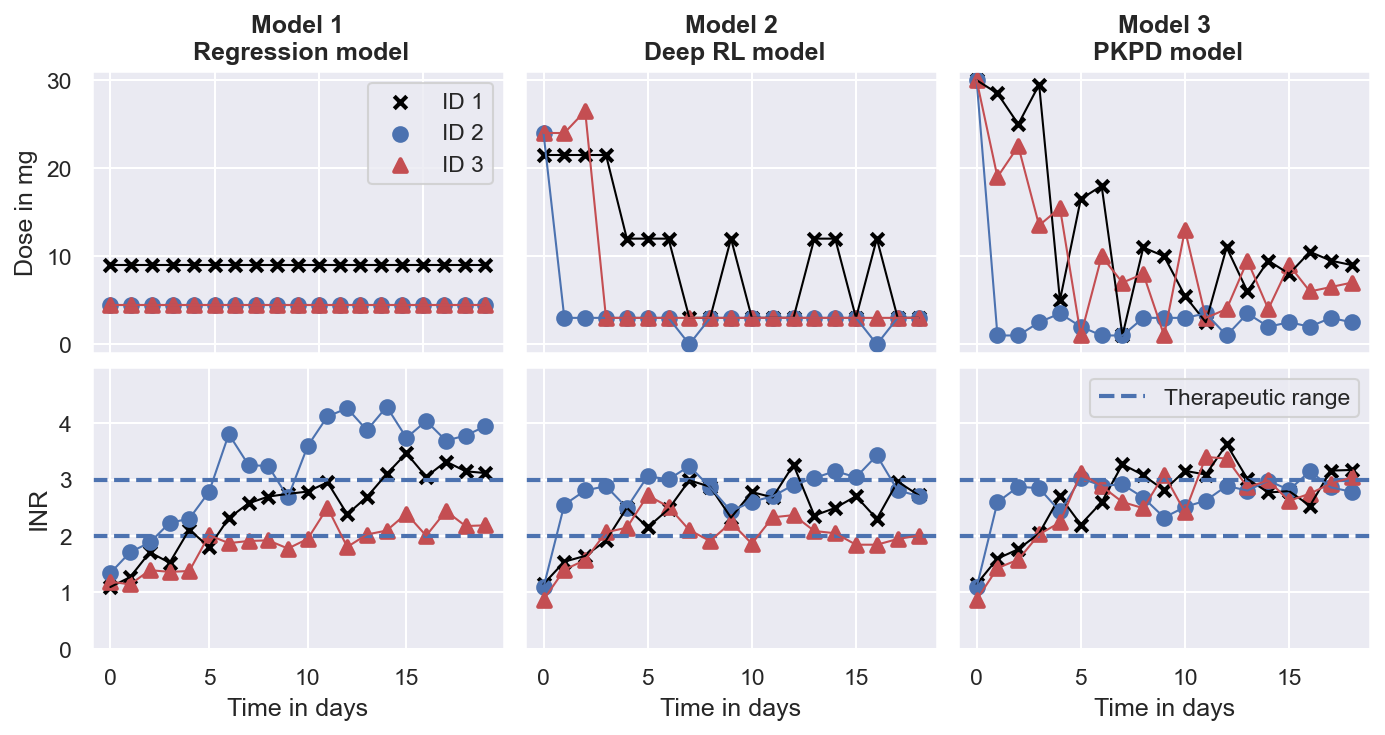

In [292]:
# Visualise results
# Create layout
fontsize = 11
my_dpi = 192
fig = plt.figure(figsize=(2250 // my_dpi, 1000 // my_dpi), dpi=150)
outer = gridspec.GridSpec(1, 3, wspace=0.05)

inner1 = gridspec.GridSpecFromSubplotSpec(
    2, 1, subplot_spec=outer[0], hspace=0.05)
inner2 = gridspec.GridSpecFromSubplotSpec(
    2, 1, subplot_spec=outer[1], hspace=0.05)
inner3 = gridspec.GridSpecFromSubplotSpec(
    2, 1, subplot_spec=outer[2], hspace=0.05)

# Create axes
axes = []
axes.append(plt.Subplot(fig, inner1[0]))
axes.append(plt.Subplot(fig, inner1[1]))
axes.append(plt.Subplot(fig, inner2[0]))
axes.append(plt.Subplot(fig, inner2[1]))
axes.append(plt.Subplot(fig, inner3[0]))
axes.append(plt.Subplot(fig, inner3[1]))

# Add axes to figure
for ax in axes:
    fig.add_subplot(ax)

axes[1].axhline(2, linestyle='--', color=sns.color_palette()[0], linewidth=2)
axes[1].axhline(3, linestyle='--', color=sns.color_palette()[0], linewidth=2)
axes[3].axhline(2, linestyle='--', color=sns.color_palette()[0], linewidth=2)
axes[3].axhline(3, linestyle='--', color=sns.color_palette()[0], linewidth=2)
axes[5].axhline(2, linestyle='--', color=sns.color_palette()[0], linewidth=2)
axes[5].axhline(
    3, linestyle='--', color=sns.color_palette()[0], linewidth=2,
    label='Therapeutic range')

# Model 1
ids = df_demo[
    (df_demo.CYP2C9 == 1)
    & (df_demo.Age > 50)
    & (df_demo.Age < 51)
    & (df_demo.VKORC1 == 1)
].ID.values[[5, 0, 1,]] - 1
ids[0] = df_demo[
    (df_demo.CYP2C9 == 0)
    & (df_demo.Age > 50)
    & (df_demo.Age < 51)
    & (df_demo.VKORC1 == 0)
].ID.values[2] - 1
axes[0].plot(
    times[:-1] / 24 - 100, doses[ids[0]], color='black', linewidth=1)
axes[0].scatter(
    times[:-1] / 24 - 100, doses[ids[0]], marker='x',
    color='black', linewidths=2, label='ID 1')
axes[1].plot(
    times / 24 - 100, inrs_1[ids[0]], color='black', linewidth=1)
axes[1].scatter(
    times / 24 - 100, inrs_1[ids[0]], marker='x',
    color='black', linewidths=2)
axes[0].plot(
    times[:-1] / 24 - 100, doses[ids[1]], color=sns.color_palette()[0],
    linewidth=1)
axes[0].scatter(
    times[:-1] / 24 - 100, doses[ids[1]], marker='o',
    color=sns.color_palette()[0], linewidths=2, label='ID 2')
axes[1].plot(
    times / 24 - 100, inrs_1[ids[1]], color=sns.color_palette()[0],
    linewidth=1)
axes[1].scatter(
    times / 24 - 100, inrs_1[ids[1]], marker='o',
    color=sns.color_palette()[0], linewidths=2)
axes[0].plot(
    times[:-1] / 24 - 100, doses[ids[2]], color=sns.color_palette()[3],
    linewidth=1)
axes[0].scatter(
    times[:-1] / 24 - 100, doses[ids[2]], marker='^',
    color=sns.color_palette()[3], linewidths=2, label='ID 3')
axes[1].plot(
    times / 24 - 100, inrs_1[ids[2]], color=sns.color_palette()[3],
    linewidth=1)
axes[1].scatter(
    times / 24 - 100, inrs_1[ids[2]], marker='^',
    color=sns.color_palette()[3], linewidths=2)

# Model 2
axes[2].plot(
    inrs_3[ids[0], :, 0], inrs_3[ids[0], :, 2], color='black', linewidth=1)
axes[2].scatter(
    inrs_3[ids[0], :, 0], inrs_3[ids[0], :, 2], marker='x',
    color='black', linewidths=2)
axes[3].plot(
    inrs_3[ids[0], :, 0], inrs_3[ids[0], :, 1], color='black', linewidth=1)
axes[3].scatter(
    inrs_3[ids[0], :, 0], inrs_3[ids[0], :, 1], marker='x',
    color='black', linewidths=2)
axes[2].plot(
    inrs_3[ids[1], :, 0], inrs_3[ids[1], :, 2], color=sns.color_palette()[0],
    linewidth=1)
axes[2].scatter(
    inrs_3[ids[1], :, 0], inrs_3[ids[1], :, 2], marker='o',
    color=sns.color_palette()[0], linewidths=2)
axes[3].plot(
    inrs_3[ids[1], :, 0], inrs_3[ids[1], :, 1], color=sns.color_palette()[0],
    linewidth=1)
axes[3].scatter(
    inrs_3[ids[1], :, 0], inrs_3[ids[1], :, 1], marker='o',
    color=sns.color_palette()[0], linewidths=2)
axes[2].plot(
    inrs_3[ids[2], :, 0], inrs_3[ids[2], :, 2], color=sns.color_palette()[3],
    linewidth=1)
axes[2].scatter(
    inrs_3[ids[2], :, 0], inrs_3[ids[2], :, 2], marker='^',
    color=sns.color_palette()[3], linewidths=2)
axes[3].plot(
    inrs_3[ids[2], :, 0], inrs_3[ids[2], :, 1], color=sns.color_palette()[3],
    linewidth=1)
axes[3].scatter(
    inrs_3[ids[2], :, 0], inrs_3[ids[2], :, 1], marker='^',
    color=sns.color_palette()[3], linewidths=2)

# Model 3
axes[4].plot(
    inrs_4[ids[0], :, 0], inrs_4[ids[0], :, 2], color='black', linewidth=1)
axes[4].scatter(
    inrs_4[ids[0], :, 0], inrs_4[ids[0], :, 2], marker='x',
    color='black', linewidths=2)
axes[5].plot(
    inrs_4[ids[0], :, 0], inrs_4[ids[0], :, 1], color='black', linewidth=1)
axes[5].scatter(
    inrs_4[ids[0], :, 0], inrs_4[ids[0], :, 1], marker='x',
    color='black', linewidths=2)
axes[4].plot(
    inrs_4[ids[1], :, 0], inrs_4[ids[1], :, 2], color=sns.color_palette()[0],
    linewidth=1)
axes[4].scatter(
    inrs_4[ids[1], :, 0], inrs_4[ids[1], :, 2], marker='o',
    color=sns.color_palette()[0], linewidths=2)
axes[5].plot(
    inrs_4[ids[1], :, 0], inrs_4[ids[1], :, 1], color=sns.color_palette()[0],
    linewidth=1)
axes[5].scatter(
    inrs_4[ids[1], :, 0], inrs_4[ids[1], :, 1], marker='o',
    color=sns.color_palette()[0], linewidths=2)
axes[4].plot(
    inrs_4[ids[2], :, 0], inrs_4[ids[2], :, 2], color=sns.color_palette()[3],
    linewidth=1)
axes[4].scatter(
    inrs_4[ids[2], :, 0], inrs_4[ids[2], :, 2], marker='^',
    color=sns.color_palette()[3], linewidths=2)
axes[5].plot(
    inrs_4[ids[2], :, 0], inrs_4[ids[2], :, 1], color=sns.color_palette()[3],
    linewidth=1)
axes[5].scatter(
    inrs_4[ids[2], :, 0], inrs_4[ids[2], :, 1], marker='^',
    color=sns.color_palette()[3], linewidths=2)

axes[0].set_ylabel('Dose in mg')
axes[0].set_xticklabels([], visible=False)
axes[1].set_ylabel('INR')
axes[1].set_xlabel('Time in days')
axes[3].set_xlabel('Time in days')
axes[5].set_xlabel('Time in days')
axes[0].set_ylim([-1, 31])
axes[1].set_ylim([0, 4.99])
axes[2].set_ylim([-1, 31])
axes[2].set_xticklabels([], visible=False)
axes[2].set_yticklabels([], visible=False)
axes[3].set_ylim([0, 4.99])
axes[3].set_yticklabels([], visible=False)
axes[4].set_ylim([-1, 31])
axes[4].set_xticklabels([], visible=False)
axes[4].set_yticklabels([], visible=False)
axes[5].set_ylim([0, 4.99])
axes[5].set_yticklabels([], visible=False)
axes[0].set_title(
    'Model 1\n Regression model', fontweight='bold')
axes[2].set_title(
    'Model 2\n Deep RL model', fontweight='bold')
axes[4].set_title(
    'Model 3\n PKPD model', fontweight='bold')

axes[0].legend()
axes[5].legend()

plt.savefig('11_dosing_strategies.pdf',
    bbox_inches='tight')
plt.savefig('11_dosing_strategies.tif',
    bbox_inches='tight')

plt.show()

## Understanding DQN

In [40]:
# Load policy
directory = os.path.dirname(os.getcwd())
data = pd.read_csv(
    directory + '/4_reinforcement_learning'
    '/policy_no_IIV.csv')
policy_1 = data[['INR', 'Dose']].values

# Load maintenance distribution
directory = os.path.dirname(os.getcwd())
df_doses = pd.read_csv(
    directory + '/4_reinforcement_learning'
    '/mipd_trial_predicted_dosing_regimens_no_IIV.csv')
df_doses = df_doses[df_doses['Number of observations'] == 19]
inrs_dqn_1 = df_doses.INR.values

# Load policy
directory = os.path.dirname(os.getcwd())
data = pd.read_csv(
    directory + '/4_reinforcement_learning'
    '/policy_no_unexplained_IIV.csv')
policy_2 = {}
for idx in range(3):
    if idx == 0:
        label = 'GG'
        temp = data[data['VKORC1 G alleles'] == 1]
    elif idx == 1:
        label = 'GA'
        temp = data[data['VKORC1 G alleles'] == 0.5]
    else:
        label = 'AA'
        temp = data[data['VKORC1 G alleles'] == 0]

    policy_2[label] = temp[['INR', 'Dose']].values

# Load maintenance distribution
directory = os.path.dirname(os.getcwd())
df_doses = pd.read_csv(
    directory + '/4_reinforcement_learning'
    '/mipd_trial_predicted_dosing_regimens_no_unexplained_IIV.csv')
df_doses = df_doses[df_doses['Number of observations'] == 19]
inrs_dqn_2 = df_doses.INR.values

# Load policy
directory = os.path.dirname(os.getcwd())
data = pd.read_csv(
    directory + '/4_reinforcement_learning'
    '/policy_explained_and_unexplained_IIV.csv')
policy_3 = {}
for idx in range(3):
    if idx == 0:
        label = 'GG'
        temp = data[data['VKORC1 G alleles'] == 1]
    elif idx == 1:
        label = 'GA'
        temp = data[data['VKORC1 G alleles'] == 0.5]
    else:
        label = 'AA'
        temp = data[data['VKORC1 G alleles'] == 0]

    policy_3[label] = temp[['INR', 'Dose']].values

# Load maintenance distribution
directory = os.path.dirname(os.getcwd())
df_doses = pd.read_csv(
    directory + '/4_reinforcement_learning'
    '/mipd_trial_predicted_dosing_regimens_no_explained_IIV.csv')
df_doses = df_doses[df_doses['Number of observations'] == 19]
inrs_dqn_3 = df_doses.INR.values

/Users/david/Workspace/sabs-r3/mipd-warfarin/venv/lib/python3.9/site-packages/seaborn/distributions.py:243: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  baselines.iloc[:, cols] = (curves
/Users/david/Workspace/sabs-r3/mipd-warfarin/venv/lib/python3.9/site-packages/seaborn/distributions.py:243: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  baselines.iloc[:, cols] = (curves
/Users/david/Workspace/sabs-r3/mipd-warfarin/venv/lib/python3.9/site-packages/seaborn/distributions.py:243: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attem

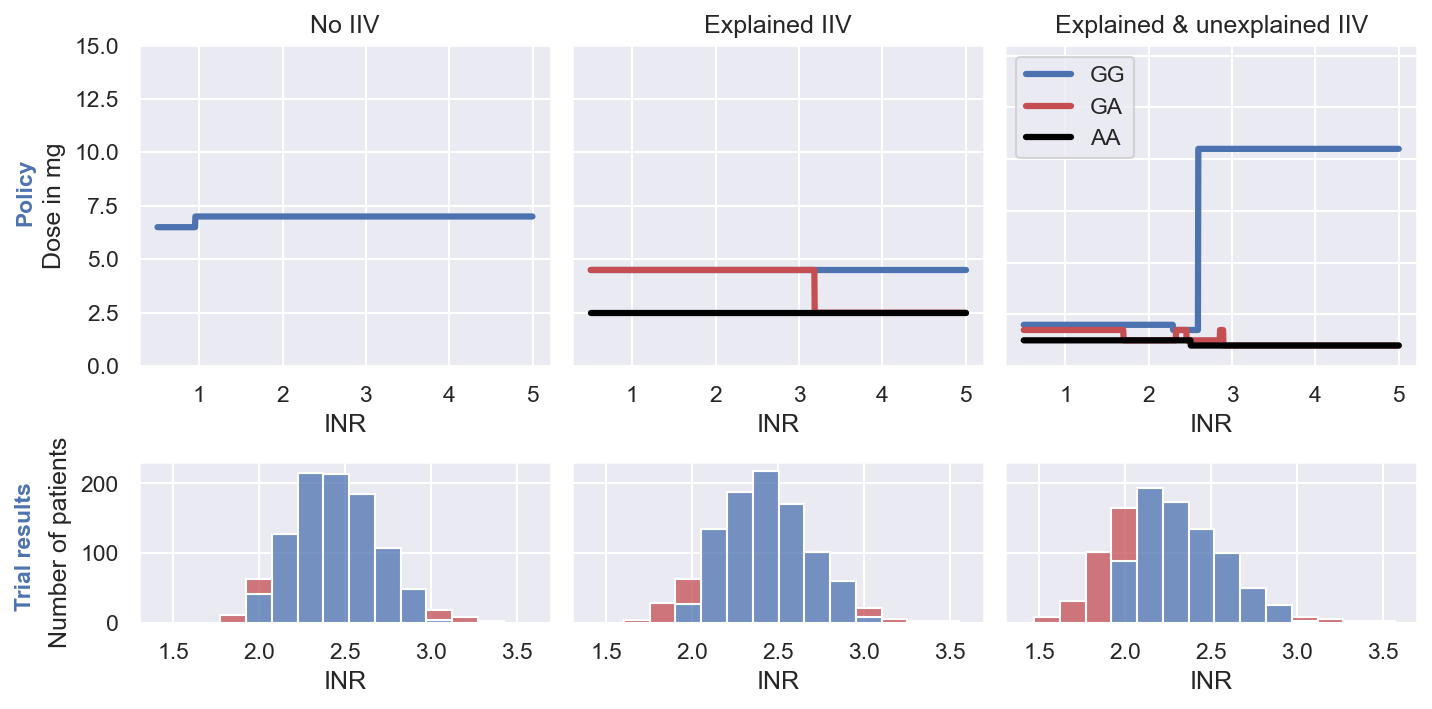

In [41]:
# Create layout
fontsize = 11
my_dpi = 192
fig = plt.figure(figsize=(2250 // my_dpi, 1000 // my_dpi), dpi=150)
outer = gridspec.GridSpec(2, 3, wspace=0.05, hspace=0.4, height_ratios=[2, 1])

# Create axes
axes = []
axes.append(plt.Subplot(fig, outer[0]))
axes.append(plt.Subplot(fig, outer[1]))
axes.append(plt.Subplot(fig, outer[2]))
axes.append(plt.Subplot(fig, outer[3]))
axes.append(plt.Subplot(fig, outer[4]))
axes.append(plt.Subplot(fig, outer[5]))

# Add axes to figure
for ax in axes:
    fig.add_subplot(ax)

axes[0].plot(policy_1[:, 0], policy_1[:, 1], linewidth=3)
df = pd.DataFrame({
    'INR': inrs_dqn_1, 'Inside TR': (inrs_dqn_1>=2) & (inrs_dqn_1<=3)})
sns.histplot(
    df, x='INR', hue='Inside TR', ax=axes[3], multiple='stack', binwidth=0.15,
    palette=[sns.color_palette()[3], sns.color_palette()[0]], legend=False)

colors = [sns.color_palette()[0], sns.color_palette()[3], 'black']
for idl, label in enumerate(policy_2.keys()):
    axes[1].plot(
        policy_2[label][:, 0], policy_2[label][:, 1], label=label,
        color=colors[idl], linewidth=3)
df = pd.DataFrame({
    'INR': inrs_dqn_2, 'Inside TR': (inrs_dqn_2>=2) & (inrs_dqn_2<=3)})
sns.histplot(
    df, x='INR', hue='Inside TR', ax=axes[4], multiple='stack', binwidth=0.15,
    palette=[sns.color_palette()[3], sns.color_palette()[0]], legend=False)

for idl, label in enumerate(policy_3.keys()):
    axes[2].plot(
        policy_3[label][:, 0], policy_3[label][:, 1], label=label,
        color=colors[idl], linewidth=3)
df = pd.DataFrame({
    'INR': inrs_dqn_3, 'Inside TR': (inrs_dqn_3>=2) & (inrs_dqn_3<=3)})
sns.histplot(
    df, x='INR', hue='Inside TR', ax=axes[5], multiple='stack', binwidth=0.15,
    palette=[sns.color_palette()[3], sns.color_palette()[0]], legend=False)

# Label axes
axes[0].set_xlabel('INR')
axes[0].set_ylabel('Dose in mg')
axes[0].set_title('No IIV')
axes[0].set_ylim([0, 15])
axes[1].set_xlabel('INR')
axes[1].set_yticklabels(labels=[], visible=False)
axes[1].set_ylabel('')
axes[1].set_title('Explained IIV')
axes[1].set_ylim([0, 15])
axes[2].set_ylabel('')
axes[2].set_yticklabels(labels=[], visible=False)
axes[2].set_xlabel('INR')
axes[2].set_title('Explained & unexplained IIV')
axes[2].set_ylim([0, 31])
axes[3].set_ylabel('Number of patients')
axes[3].set_xlim([1.3, 3.7])
axes[3].set_ylim([0, 230])
axes[4].set_yticklabels(labels=[], visible=False)
axes[4].set_ylabel('')
axes[4].set_xlim([1.3, 3.7])
axes[4].set_ylim([0, 230])
axes[5].set_yticklabels(labels=[], visible=False)
axes[5].set_ylabel('')
axes[5].set_xlim([1.3, 3.7])
axes[5].set_ylim([0, 230])

axes[0].text(
    -0.3, 0.45, 'Policy', transform=axes[0].transAxes,
    size=11, weight='bold', color=sns.color_palette()[0], rotation=90)
axes[3].text(
    -0.3, 0.1, 'Trial results', transform=axes[3].transAxes,
    size=11, weight='bold', color=sns.color_palette()[0], rotation=90)

axes[2].legend()

# plt.savefig('12_dqn_dosing_policy.pdf',
#     bbox_inches='tight')
# plt.savefig('12_dqn_dosing_policy.tif',
#     bbox_inches='tight')

plt.show()

TODO: Reduce to 5 actions, because we want to train model offline. Start all regimens at 7.5. Actions are decrease one unit, 2 units or 5 units. You always have to sit out 3 days.

## Predictive performance of BDRO

In [298]:
# Define model
model, _ = define_wajima_model(patient=True, inr_test=True)

# Get patient parameters
ids = df_demo.ID.dropna().unique()
parameters = np.empty(shape=(len(ids), model.n_parameters()))
for idx, _id in enumerate(ids):
    temp = df_demo[df_demo.ID == _id]
    parameters[idx] = temp[model.parameters()].values[0]

# Define IOV and EV
ids = df_doses.ID.dropna().unique()
rng = np.random.default_rng(seed=4)
delays = rng.exponential(scale=0.5, size=(days, len(ids)))
vk_input = get_vk_consumption(days+1, len(ids), seed=14)

n_data = np.arange(0, 20)
run = 0
try:
    run = len(inr_sequence)
except NameError:
    inr_sequence = []
for n in n_data:
    if n < run:
        continue
    # Load dosing strategy
    directory = os.path.dirname(os.getcwd())
    df_doses = pd.read_csv(
        directory + '/2_semi_mechanistic_model'
        '/mipd_trial_predicted_dosing_regimens.csv')
    df_doses = df_doses[df_doses['Number of observations'] == n]

    # Convert dosing strategy to dosing regimens
    days = 19
    cal_time = 100 * 24
    duration = 0.01
    dosing_regimens = {}
    doses = np.empty(shape=(len(df_doses.ID.dropna().unique()), days))
    for idx, _id in enumerate(df_doses.ID.dropna().unique()):
        temp = df_doses[df_doses.ID == _id]
        doses[idx] = \
            temp[['Dose %d in mg' % (idx+1) for idx in range(days)]].values[0]

    # Simulate INR response to treatment
    error_model = chi.LogNormalErrorModel()
    times = cal_time + np.array([0, 19]) * 24
    sim = np.empty(shape=(len(ids), len(times)-1))
    for idx, _id in enumerate(ids):
        # Set dosing regimen
        dr = define_dosing_regimen(doses[idx], delays=delays[:, idx])
        model.set_dosing_regimen(dr)

        # Simulate treatment response
        mask = ids == _id
        sim[idx] = model.simulate(
            parameters=parameters[mask][0],
            times=times, vk_input=vk_input[:, idx])[0, -1]
        sim[idx] = error_model.sample(
            parameters=[0.1], model_output=sim[idx])[0, 0]

    inr_sequence.append(sim[:, -1])

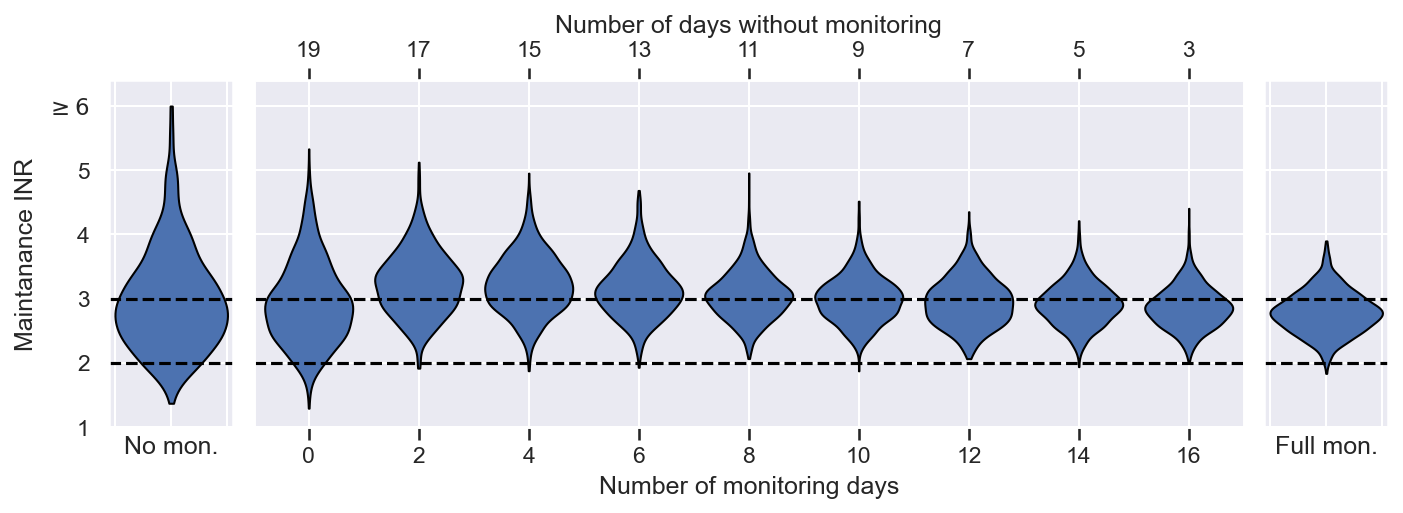

In [323]:
# Create layout
fontsize = 11
my_dpi = 192
fig = plt.figure(figsize=(2250 // my_dpi, 700 // my_dpi), dpi=150)
outer = gridspec.GridSpec(1, 3, width_ratios=[1, len(n_data)/2-2, 1], wspace=0.05)

# Create axes
axes = []
axes.append(plt.Subplot(fig, outer[0]))
axes.append(plt.Subplot(fig, outer[1]))
axes.append(plt.Subplot(fig, outer[2]))

# Add axes to figure
for ax in axes:
    fig.add_subplot(ax)

axes[0].axhline(3, color='black', linestyle='dashed')
axes[0].axhline(2, color='black', linestyle='dashed')
axes[1].axhline(3, color='black', linestyle='dashed')
axes[1].axhline(2, color='black', linestyle='dashed')
axes[2].axhline(3, color='black', linestyle='dashed')
axes[2].axhline(2, color='black', linestyle='dashed')

axes[0].set_ylim([1, 6.4])
axes[0].set_ylabel('Maintanance INR')
axes[0].set_xlabel('No mon.')
axes[0].set_xticklabels(labels=[], visible=False)
axes[0].set_yticks([1, 2, 3, 4, 5, 6])
axes[0].set_yticklabels(labels=['1', '2', '3', '4', '5', r'$\geq 6$'])
axes[1].set_ylim([1, 6.4])
axes[1].set_ylabel('')
axes[1].set_xlim([-1, 17])
axes[1].set_yticklabels(labels=[], visible=False)
axes[1].set_xticks([0, 2, 4, 6, 8, 10, 12, 14, 16])
axes[1].set_xlabel('Number of monitoring days')
axes[1].annotate('TR', xy=(n_data[-1]-0.6, 2.1))
axes[2].set_ylim([1, 6.4])
axes[2].set_xlabel('Full mon.')
axes[2].set_yticklabels(labels=[], visible=False)
axes[2].set_xticklabels(labels=[], visible=False)

# Add a second x axis on top
ax_top = axes[1].twiny()
ax_top.set_xlim(axes[1].get_xlim())
ax_top.set_xticks([0, 2, 4, 6, 8, 10, 12, 14, 16])
ax_top.set_xticklabels(19 - np.array([0, 2, 4, 6, 8, 10, 12, 14, 16]))
ax_top.grid(False)
ax_top.set_xlabel('Number of days without monitoring')

# Set INRs > 6 to 6 and label in image
mask = inr_sequence[0] > 6
inr_sequence[0][mask] = 6

dicts = axes[1].violinplot(
    inr_sequence[1:-1:2], n_data[1:-1:2] - 1, showextrema=False,
    widths=[1.6] * len(inr_sequence[1:-1:2]))
for part in dicts['bodies']:
    part.set_edgecolor('black')
    part.set_alpha(1)
dicts = axes[0].violinplot(
    [inr_sequence[0]], [-1], showextrema=False)
for part in dicts['bodies']:
    part.set_edgecolor('black')
    part.set_alpha(1)
dicts = axes[2].violinplot(
    [inrs_4[:, -1, 1]], [19], showextrema=False)
for part in dicts['bodies']:
    part.set_edgecolor('black')
    part.set_alpha(1)

plt.savefig('13_bdro_over_time.pdf',
    bbox_inches='tight')
plt.savefig('13_bdro_over_time.tif',
    bbox_inches='tight')

plt.show()

## Virtual clinical trial data used for calibration

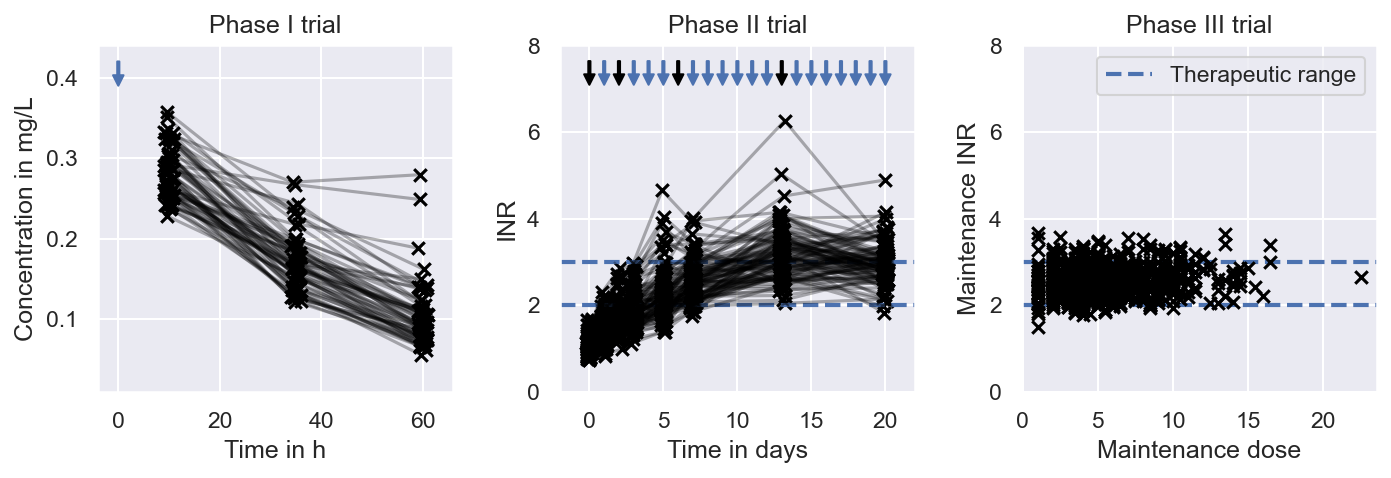

In [55]:
# Visualise results
# Create layout
fontsize = 11
my_dpi = 192
fig = plt.figure(figsize=(2250 // my_dpi, 700 // my_dpi), dpi=150)
outer = gridspec.GridSpec(1, 3, wspace=0.3)

# Create axes
axes = []
axes.append(plt.Subplot(fig, outer[0]))
axes.append(plt.Subplot(fig, outer[1]))
axes.append(plt.Subplot(fig, outer[2]))


# Add axes to figure
for ax in axes:
    fig.add_subplot(ax)

axes[2].sharey(axes[1])

# Visualise trial phase I
directory = os.path.dirname(os.getcwd())
data = pd.read_csv(directory + '/data/trial_phase_I.csv')
data = data[data.Observable == 'central_warfarin.warfarin_concentration']
ids = data.ID.dropna().unique()
times = data.Time.dropna().unique()
concs = np.empty(shape=(len(ids), len(times)))
for idx, _id in enumerate(ids):
    concs[idx] = data[data.ID == _id].Value.values
for c in concs:
    jitter = np.random.uniform(-1, 1, size=len(times))
    axes[0].plot(
        times + jitter, c, marker='x', color='black',
        alpha=0.3)
    axes[0].scatter(
        times + jitter, c, marker='x', color='black')

# Visualise dose point
axes[0].annotate(
    "", xy=(0, 0.39), xytext=(0, 0.42),
    arrowprops=dict(width=1, headwidth=5, headlength=5,
    color=sns.color_palette()[0]))

# Visualise therapeutic range
axes[1].axhline(
    2, linestyle='--', color=sns.color_palette()[0], linewidth=2)
axes[1].axhline(
    3, linestyle='--', color=sns.color_palette()[0], linewidth=2)
axes[2].axhline(
    2, linestyle='--', color=sns.color_palette()[0], linewidth=2)
axes[2].axhline(
    3, linestyle='--', color=sns.color_palette()[0], linewidth=2,
    label='Therapeutic range')

# Visualise trial phase II
data = pd.read_csv(directory + '/data/trial_phase_II.csv')
temp = data[data.Observable == 'INR']
ids = temp.ID.dropna().unique()
times2 = temp.Time.dropna().unique() // 24
inrs2 = np.empty(shape=(len(ids), len(times2)))
for idx, _id in enumerate(ids):
    inrs2[idx] = temp[temp.ID == _id].Value.values
    mask = data.ID == _id
for c in inrs2:
    jitter = np.random.uniform(-0.2, 0.2, size=len(times2))
    axes[1].plot(
        times2 + jitter, c, marker='x', color='black',
        alpha=0.3)
    axes[1].scatter(
        times2 + jitter, c, marker='x', color='black')

# Visualise dose point
for t in range(21):
    color = sns.color_palette()[0]
    if t in [0, 2, 6, 13]:
        color = 'black'
    axes[1].annotate(
        "", xy=(t, 0.39 / 0.44 * 8), xytext=(t, 0.42 / 0.44 * 8),
        arrowprops=dict(width=1, headwidth=5, headlength=5,
        color=color)
    )

# Visualise trial phase III
data = pd.read_csv(directory + '/data/trial_phase_III.csv')
mask = \
    (data.Observable != 'INR') | (
    (data.Observable == 'INR') & (data.Time == 1320))
data = data[mask]
temp = data[data.Observable == 'INR']
ids = temp.ID.dropna().unique()
inrs_3 = np.empty(shape=len(ids))
doses_3 = np.empty(shape=(len(ids)))
for idx, _id in enumerate(ids):
    inrs_3[idx] = temp[temp.ID == _id].Value.values
    mask = data.ID == _id
    doses_3[idx] = data[mask].Dose.dropna().values[-1]
axes[2].scatter(
    doses_3, inrs_3, marker='x', color='black', zorder=10)


axes[0].set_title('Phase I trial')
axes[1].set_title('Phase II trial')
axes[2].set_title('Phase III trial')

# Label axes
axes[0].set_xlabel('Time in h')
axes[0].set_ylabel('Concentration in mg/L')
axes[0].set_xlim([-4, 66])
axes[0].set_ylim([0.01, 0.44])

axes[1].set_xlabel('Time in days')
axes[1].set_ylabel('INR')
axes[1].set_xlim([-2, 22])
axes[1].set_ylim([0, 8])

axes[2].set_xlabel('Maintenance dose')
axes[2].set_ylabel('Maintenance INR')

axes[2].legend()

plt.savefig('14_phase_I_II_III.pdf',
    bbox_inches='tight')
plt.savefig('14_phase_I_II_III.tif',
    bbox_inches='tight')

plt.show()